In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.feature_selection import SelectKBest, chi2


for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


/kaggle/input/indian-candidates-for-general-election-2019/LS_2.0.csv


## Reading the Dataset

In [2]:
dataset = pd.read_csv('/kaggle/input/indian-candidates-for-general-election-2019/LS_2.0.csv')
dataset.head()

,STATE,CONSTITUENCY,NAME,WINNER,PARTY,SYMBOL,GENDER,CRIMINAL\nCASES,AGE,CATEGORY,EDUCATION,ASSETS,LIABILITIES,GENERAL\nVOTES,POSTAL\nVOTES,TOTAL\nVOTES,OVER TOTAL ELECTORS \nIN CONSTITUENCY,OVER TOTAL VOTES POLLED \nIN CONSTITUENCY,TOTAL ELECTORS
0,Telangana,ADILABAD,SOYAM BAPU RAO,1,BJP,Lotus,MALE,52,52.0,ST,12th Pass,"Rs 30,99,414\n ~ 30 Lacs+","Rs 2,31,450\n ~ 2 Lacs+",376892,482,377374,25.330684,35.468248,1489790
1,Telangana,ADILABAD,Godam Nagesh,0,TRS,Car,MALE,0,54.0,ST,Post Graduate,"Rs 1,84,77,888\n ~ 1 Crore+","Rs 8,47,000\n ~ 8 Lacs+",318665,149,318814,21.399929,29.964370,1489790
2,Telangana,ADILABAD,RATHOD RAMESH,0,INC,Hand,MALE,3,52.0,ST,12th Pass,"Rs 3,64,91,000\n ~ 3 Crore+","Rs 1,53,00,000\n ~ 1 Crore+",314057,181,314238,21.092771,29.534285,1489790
3,Telangana,ADILABAD,NOTA,0,NOTA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,13030,6,13036,0.875023,1.225214,1489790
4,Uttar Pradesh,AGRA,Satyapal Singh Baghel,1,BJP,Lotus,MALE,5,58.0,SC,Doctorate,"Rs 7,42,74,036\n ~ 7 Crore+","Rs 86,06,522\n ~ 86 Lacs+",644459,2416,646875,33.383823,56.464615,1937690


In [3]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2263 entries, 0 to 2262
Data columns (total 19 columns):
STATE                                       2263 non-null object
CONSTITUENCY                                2263 non-null object
NAME                                        2263 non-null object
WINNER                                      2263 non-null int64
PARTY                                       2263 non-null object
SYMBOL                                      2018 non-null object
GENDER                                      2018 non-null object
CRIMINAL
CASES                              2018 non-null object
AGE                                         2018 non-null float64
CATEGORY                                    2018 non-null object
EDUCATION                                   2018 non-null object
ASSETS                                      2018 non-null object
LIABILITIES                                 2018 non-null object
GENERAL
VOTES                               2263

In [4]:
dataset.describe()

,WINNER,AGE,GENERAL\nVOTES,POSTAL\nVOTES,TOTAL\nVOTES,OVER TOTAL ELECTORS \nIN CONSTITUENCY,OVER TOTAL VOTES POLLED \nIN CONSTITUENCY,TOTAL ELECTORS
count,2263.000000,2018.000000,2.263000e+03,2263.000000,2.263000e+03,2263.000000,2263.000000,2.263000e+03
mean,0.238179,52.273538,2.615991e+05,990.710561,2.625898e+05,15.811412,23.190525,1.658016e+06
std,0.426064,11.869373,2.549906e+05,1602.839174,2.559822e+05,14.962861,21.564758,3.145187e+05
min,0.000000,25.000000,1.339000e+03,0.000000,1.342000e+03,0.097941,1.000039,5.518900e+04
25%,0.000000,43.250000,2.103450e+04,57.000000,2.116250e+04,1.296518,1.899502,1.530014e+06
50%,0.000000,52.000000,1.539340e+05,316.000000,1.544890e+05,10.510553,16.221721,1.679030e+06
75%,0.000000,61.000000,4.858040e+05,1385.000000,4.872315e+05,29.468185,42.590233,1.816857e+06
max,1.000000,86.000000,1.066824e+06,19367.000000,1.068569e+06,51.951012,74.411856,3.150313e+06


In [5]:
dataset.shape

(2263, 19)

## Cleaning the Dataset

In [6]:
# rename invalid column names
dataset = dataset.rename(columns={'CRIMINAL\nCASES': 'CRIMINAL_CASES', 'GENERAL\nVOTES': 'GENERAL_VOTES', 'POSTAL\nVOTES': 'POSTAL_VOTES', 'TOTAL\nVOTES': 'TOTAL_VOTES', 'OVER TOTAL ELECTORS \nIN CONSTITUENCY': 'OVER_TOTAL_ELECTORS_IN_CONSTITUENCY', 'OVER TOTAL VOTES POLLED \nIN CONSTITUENCY': 'OVER_TOTAL_VOTES_POLLED_IN_CONSTITUENCY', 'TOTAL ELECTORS': 'TOTAL_ELECTORS'})

# drop rows with NA values
dataset = dataset[dataset['GENDER'].notna()]

# replace Nil values with 0
dataset['ASSETS'] = dataset['ASSETS'].replace(['Nil', '`', 'Not Available'], '0')
dataset['LIABILITIES'] = dataset['LIABILITIES'].replace(['NIL', '`', 'Not Available'], '0')
dataset['CRIMINAL_CASES'] = dataset['CRIMINAL_CASES'].replace(['Not Available'], '0')

# clean ASSETS and LIABILITIES column values
dataset['ASSETS'] = dataset['ASSETS'].map(lambda x: x.lstrip('Rs ').split('\n')[0].replace(',', ''))
dataset['LIABILITIES'] = dataset['LIABILITIES'].map(lambda x: x.lstrip('Rs ').split('\n')[0].replace(',', ''))

# convert ASSETS, LIABILITIES and CRIMINAL_CASES column values into numeric
dataset['ASSETS'] = dataset['ASSETS'].astype(str).astype(float)
dataset['LIABILITIES'] = dataset['LIABILITIES'].astype(str).astype(float)
dataset['CRIMINAL_CASES'] = dataset['CRIMINAL_CASES'].astype(str).astype(int)

# reorder columns
cols = dataset.columns.tolist()
cols = cols[0:3] + cols[4:] + cols[3:4]
dataset = dataset[cols]

In [7]:
dataset.head()

dataset.isna().sum()

STATE                                      0
CONSTITUENCY                               0
NAME                                       0
PARTY                                      0
SYMBOL                                     0
GENDER                                     0
CRIMINAL_CASES                             0
AGE                                        0
CATEGORY                                   0
EDUCATION                                  0
ASSETS                                     0
LIABILITIES                                0
GENERAL_VOTES                              0
POSTAL_VOTES                               0
TOTAL_VOTES                                0
OVER_TOTAL_ELECTORS_IN_CONSTITUENCY        0
OVER_TOTAL_VOTES_POLLED_IN_CONSTITUENCY    0
TOTAL_ELECTORS                             0
WINNER                                     0
dtype: int64

## Basic Feature Engineering

In [8]:
dataset['PARTY'].value_counts()

BJP       420
INC       413
IND       201
BSP       163
CPI(M)    100
         ... 
ASDC        1
KEC(M)      1
JAPL        1
MSHP        1
MOSP        1
Name: PARTY, Length: 132, dtype: int64

In [9]:
# change party of the less frequent parties as Other
# 'BJP','INC','IND','BSP', 'CPI(M)', 'AITC', 'MNM': high frequent
# 'TDP', 'VSRCP', 'SP', 'DMK', 'BJD': medium frequent

dataset.loc[~dataset["PARTY"].isin(['BJP','INC','IND','BSP', 'CPI(M)', 'AITC', 'MNM', 'TDP', 'VSRCP', 'SP', 'DMK', 'BJD']), "PARTY"] = "Other"
dataset['PARTY'].value_counts()


Other     530
BJP       420
INC       413
IND       201
BSP       163
CPI(M)    100
AITC       47
SP         39
MNM        36
TDP        25
DMK        23
BJD        21
Name: PARTY, dtype: int64

In [10]:
dataset['CATEGORY'].value_counts()

GENERAL    1392
SC          383
ST          243
Name: CATEGORY, dtype: int64

In [11]:
dataset['EDUCATION'].value_counts()

Post Graduate            502
Graduate                 441
Graduate Professional    336
12th Pass                256
10th Pass                196
8th Pass                  78
Doctorate                 73
Others                    50
Literate                  30
5th Pass                  28
Not Available             22
Illiterate                 5
Post Graduate\n            1
Name: EDUCATION, dtype: int64

In [12]:
# encode education column
encoded_edu = []

# iterate through each row in the dataset
for row in dataset.itertuples():
    education = row.EDUCATION

    if education == "Illiterate":
        encoded_edu.append(0)
    elif education == "Literate":
        encoded_edu.append(1)
    elif education == "5th Pass":
        encoded_edu.append(2)
    elif education == "8th Pass":
        encoded_edu.append(3)
    elif education == "10th Pass":
        encoded_edu.append(4)
    elif education == "12th Pass":
        encoded_edu.append(7)
    elif education == "Graduate":
        encoded_edu.append(8)
    elif education == "Post Graduate":
        encoded_edu.append(9)
    elif education == "Graduate Professional":
        encoded_edu.append(10)
    elif education == "Doctorate":
        encoded_edu.append(11)
    else:
        encoded_edu.append(5)

dataset['EDUCATION'] = encoded_edu


## Creating New Feature Columns

In [13]:
# Preparing feature values

cons_per_state = {}
voters_per_state = {}

party_winningSeats = {}
party_criminal = {}
party_education = {}

party_totalCandidates_per_cons = {}
party_winningSeats_per_cons = {}
party_criminal_per_cons = {}
party_education_per_cons = {}

voters_per_cons = {}


# group by state
subset = dataset[['STATE', 'CONSTITUENCY', 'TOTAL_ELECTORS']]
gk = subset.groupby('STATE')

# for each state
for name,group in gk:
    # total constituencies per state
    cons_per_state[name] = len(group)
    
    # total voters per state
    voters_per_state[name] = group['TOTAL_ELECTORS'].sum()


# group by party
subset = dataset[['PARTY', 'CONSTITUENCY', 'CRIMINAL_CASES', 'EDUCATION', 'WINNER']]
gk = subset.groupby('PARTY')

# for each party
for name,group in gk:
    # winning seats by party
    party_winningSeats[name] = group[group['WINNER'] == 1.0].shape[0]
    
    # criminal cases by party
    party_criminal[name] = group['CRIMINAL_CASES'].sum()
    
    # education qualification by party (sum of candidates)
    party_education[name] = group['EDUCATION'].sum()
    
    # group by constituency
    gk2 = group.groupby('CONSTITUENCY')
    
    # for each constituency
    for name2, group2 in gk2:
        key = name2 + '_' + name    # cons_party
        
        # total candidates by party in constituency
        party_totalCandidates_per_cons[key] = len(group2)
        
        # party winning seats in the constituency
        party_winningSeats_per_cons[key] = group2[group2['WINNER'] == 1.0].shape[0]
        
        # criminal cases by party in the constituency
        party_criminal_per_cons[key] = group2['CRIMINAL_CASES'].sum()

        # education qualification by party in constituency (sum of candidates)
        party_education_per_cons[key] = group2['EDUCATION'].sum()


# Total voters per constituency
subset = dataset[['CONSTITUENCY', 'TOTAL_ELECTORS']]
gk = subset.groupby('CONSTITUENCY')

# for each constituency
for name,group in gk:
    voters_per_cons[name] = len(group)


In [14]:
# Applying feature values

# new feature columns
total_cons_per_state = []
total_voters_per_state = []
total_voters_per_cons = []

winning_seats_by_party = []
criminal_by_party = []
education_by_party = []

total_candidates_by_party_per_cons = []
winning_seats_by_party_per_cons = []
criminal_by_party_per_cons = []
education_by_party_per_cons = []


# iterate through each row in the dataset
for row in dataset.itertuples():
    subkey = row.CONSTITUENCY + '_' + row.PARTY

    total_cons_per_state.append(cons_per_state.get(row.STATE))
    total_voters_per_state.append(voters_per_state.get(row.STATE))
    total_voters_per_cons.append(voters_per_cons.get(row.CONSTITUENCY))
    winning_seats_by_party.append(party_winningSeats.get(row.PARTY))
    criminal_by_party.append(party_criminal.get(row.PARTY))
    education_by_party.append(party_education.get(row.PARTY))
    total_candidates_by_party_per_cons.append(party_totalCandidates_per_cons.get(subkey))
    winning_seats_by_party_per_cons.append(party_winningSeats_per_cons.get(subkey))
    criminal_by_party_per_cons.append(party_criminal_per_cons.get(subkey))
    education_by_party_per_cons.append(party_education_per_cons.get(subkey))


# append columns to dataset
dataset['total_cons_per_state'] = total_cons_per_state
dataset['total_voters_per_state'] = total_voters_per_state
dataset['total_voters_per_cons'] = total_voters_per_cons
dataset['winning_seats_by_party'] = winning_seats_by_party
dataset['criminal_by_party'] = criminal_by_party
dataset['education_by_party'] = education_by_party
dataset['total_candidates_by_party_per_cons'] = total_candidates_by_party_per_cons
dataset['winning_seats_by_party_per_cons'] = winning_seats_by_party_per_cons
dataset['criminal_by_party_per_cons'] = criminal_by_party_per_cons
dataset['education_by_party_per_cons'] = education_by_party_per_cons


## Label Encoding and Normalization

In [15]:
# label encode categorical columns

lblEncoder_state = LabelEncoder()
lblEncoder_state.fit(dataset['STATE'])
dataset['STATE'] = lblEncoder_state.transform(dataset['STATE'])

lblEncoder_cons = LabelEncoder()
lblEncoder_cons.fit(dataset['CONSTITUENCY'])
dataset['CONSTITUENCY'] = lblEncoder_cons.transform(dataset['CONSTITUENCY'])

lblEncoder_name = LabelEncoder()
lblEncoder_name.fit(dataset['NAME'])
dataset['NAME'] = lblEncoder_name.transform(dataset['NAME'])

lblEncoder_party = LabelEncoder()
lblEncoder_party.fit(dataset['PARTY'])
dataset['PARTY'] = lblEncoder_party.transform(dataset['PARTY'])

lblEncoder_symbol = LabelEncoder()
lblEncoder_symbol.fit(dataset['SYMBOL'])
dataset['SYMBOL'] = lblEncoder_symbol.transform(dataset['SYMBOL'])

lblEncoder_gender = LabelEncoder()
lblEncoder_gender.fit(dataset['GENDER'])
dataset['GENDER'] = lblEncoder_gender.transform(dataset['GENDER'])

lblEncoder_category = LabelEncoder()
lblEncoder_category.fit(dataset['CATEGORY'])
dataset['CATEGORY'] = lblEncoder_category.transform(dataset['CATEGORY'])


In [16]:
# scaling values into 0-1 range

scaler = MinMaxScaler(feature_range=(0, 1))
features = [
    'STATE', 'CONSTITUENCY', 'NAME', 'PARTY', 'SYMBOL', 'GENDER', 'CRIMINAL_CASES', 'AGE', 'CATEGORY', 'EDUCATION', 'ASSETS', 'LIABILITIES', 'GENERAL_VOTES', 'POSTAL_VOTES', 'TOTAL_VOTES', 'OVER_TOTAL_ELECTORS_IN_CONSTITUENCY', 'OVER_TOTAL_VOTES_POLLED_IN_CONSTITUENCY', 'TOTAL_ELECTORS',
     'total_cons_per_state', 'total_voters_per_state', 'total_voters_per_cons', 'winning_seats_by_party', 'criminal_by_party', 'education_by_party', 'total_candidates_by_party_per_cons', 'winning_seats_by_party_per_cons', 'criminal_by_party_per_cons', 'education_by_party_per_cons'
]

dataset[features] = scaler.fit_transform(dataset[features])


In [17]:
# separate train features and label
y = dataset["WINNER"]
X = dataset.drop(labels=["WINNER"], axis=1)


## Feature Importance

In [18]:
# apply SelectKBest class to extract top most features
bestfeatures = SelectKBest(score_func=chi2, k=10)
fit = bestfeatures.fit(X, y)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X.columns)

# concat two dataframes for better visualization 
featureScores = pd.concat([dfcolumns, dfscores], axis=1)
featureScores.columns = ['Specs', 'Score']
print(featureScores.nlargest(30, 'Score'))


                                      Specs       Score
25          winning_seats_by_party_per_cons  486.207788
16  OVER_TOTAL_VOTES_POLLED_IN_CONSTITUENCY  285.347141
15      OVER_TOTAL_ELECTORS_IN_CONSTITUENCY  262.177373
14                              TOTAL_VOTES  216.937788
12                            GENERAL_VOTES  216.138799
21                   winning_seats_by_party  199.662525
13                             POSTAL_VOTES   65.126864
22                        criminal_by_party   36.519437
3                                     PARTY   35.416433
23                       education_by_party    6.576548
11                              LIABILITIES    6.330339
24       total_candidates_by_party_per_cons    5.755538
20                    total_voters_per_cons    5.302656
4                                    SYMBOL    4.128283
8                                  CATEGORY    4.047031
10                                   ASSETS    3.755575
7                                       AGE    2

In [19]:
# remove unnecessary columns

X.drop(labels=["NAME"], axis=1, inplace=True)
X.drop(labels=["SYMBOL"], axis=1, inplace=True)
X.drop(labels=["POSTAL_VOTES"], axis=1, inplace=True)
X.drop(labels=["GENERAL_VOTES"], axis=1, inplace=True)

X.drop(labels=["TOTAL_ELECTORS"], axis=1, inplace=True)
X.drop(labels=["STATE"], axis=1, inplace=True)
X.drop(labels=["CONSTITUENCY"], axis=1, inplace=True)
X.drop(labels=["GENDER"], axis=1, inplace=True)
X.drop(labels=["criminal_by_party_per_cons"], axis=1, inplace=True)
X.drop(labels=["total_voters_per_state"], axis=1, inplace=True)
X.drop(labels=["CRIMINAL_CASES"], axis=1, inplace=True)
X.drop(labels=["total_cons_per_state"], axis=1, inplace=True)
X.drop(labels=["EDUCATION"], axis=1, inplace=True)
X.drop(labels=["education_by_party_per_cons"], axis=1, inplace=True)
X.drop(labels=["AGE"], axis=1, inplace=True)


## Spliting Dataset into Training and Testing

In [20]:
# split dataset into train and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1, stratify=y)


## Train and Test the Model

In [21]:
knn = KNeighborsClassifier()
knn.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

In [22]:
knn.predict(X_test)
print("Testing Accuracy is: ", knn.score(X_test, y_test)*100, "%")

Testing Accuracy is:  99.5049504950495 %


## Correlation Matrix

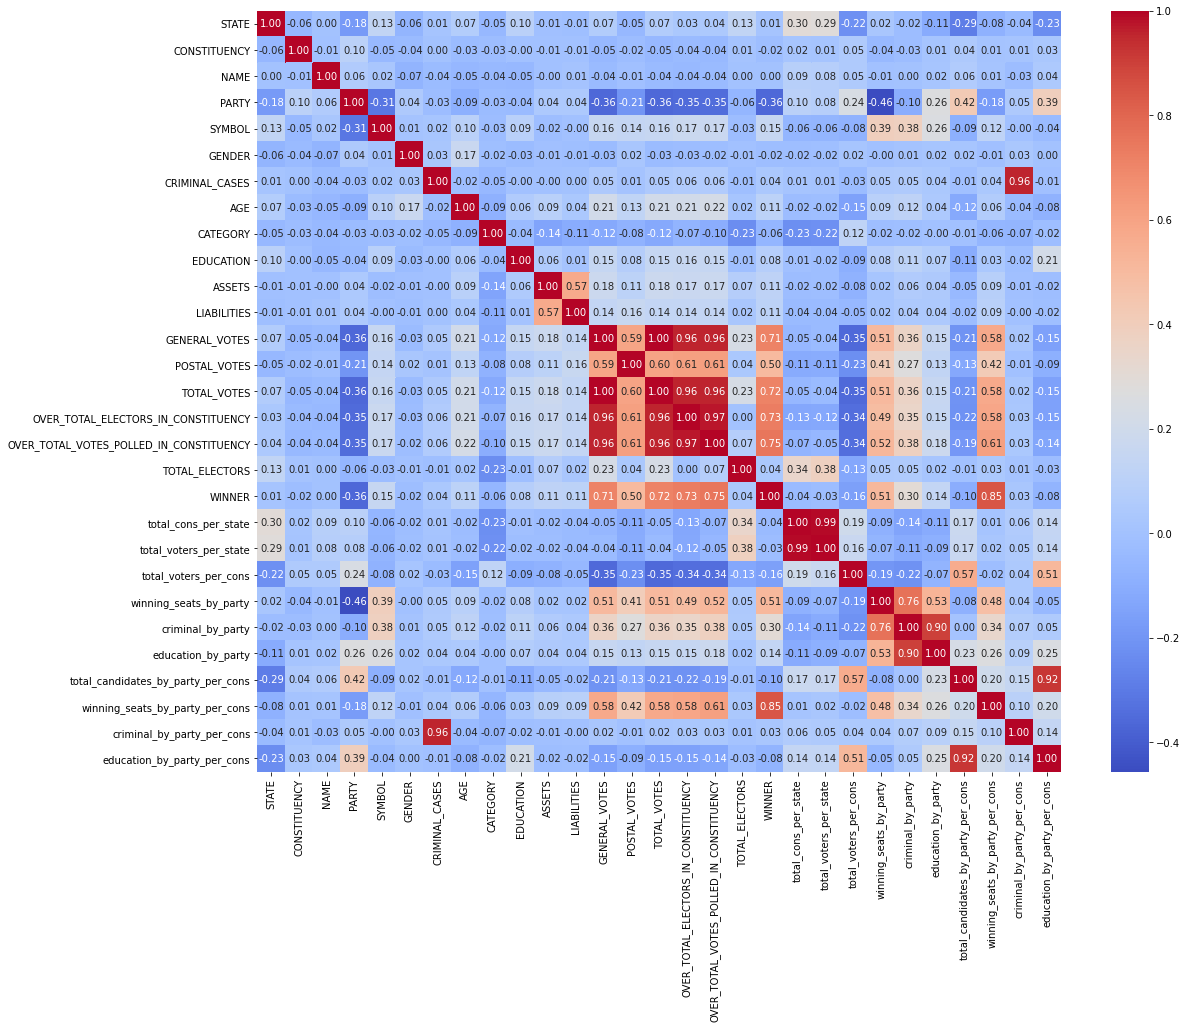

In [23]:
figsize=(18,14)
fig, ax = plt.subplots(figsize=figsize)
sns.heatmap(dataset.corr(), annot=True, fmt=".2f", cmap="coolwarm", ax=ax)

## just to visualize correlated features